# Discriminant Classification: Gravitational Waves

### WIP - Unfinished!!

In [106]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve

from matplotlib.lines import Line2D

import h5py


import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 500

### Dataset Keys
chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, dec, det, iota, mtot, psi, q, psi, q, ra, snr, z

In [61]:
file = '../../sample_2e7_design_precessing_higherordermodes_3detectors.h5'
dset = h5py.File(file, 'r')

In [62]:
dset.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

### Det Values:

Det == 0 -> Not detectable (snr < 12)

Det == 1 -> Detectable (snr > 12)

In [63]:
#To gather a specific key: data = dset.get('key') 

In [64]:
det = dset.get('det')
q = dset.get('q')
mtot = dset.get('mtot')
snr = dset.get('snr')

colors = ['green', 'blue']
mask = [det[:3]==0]
print(mask)


[array([ True,  True,  True])]


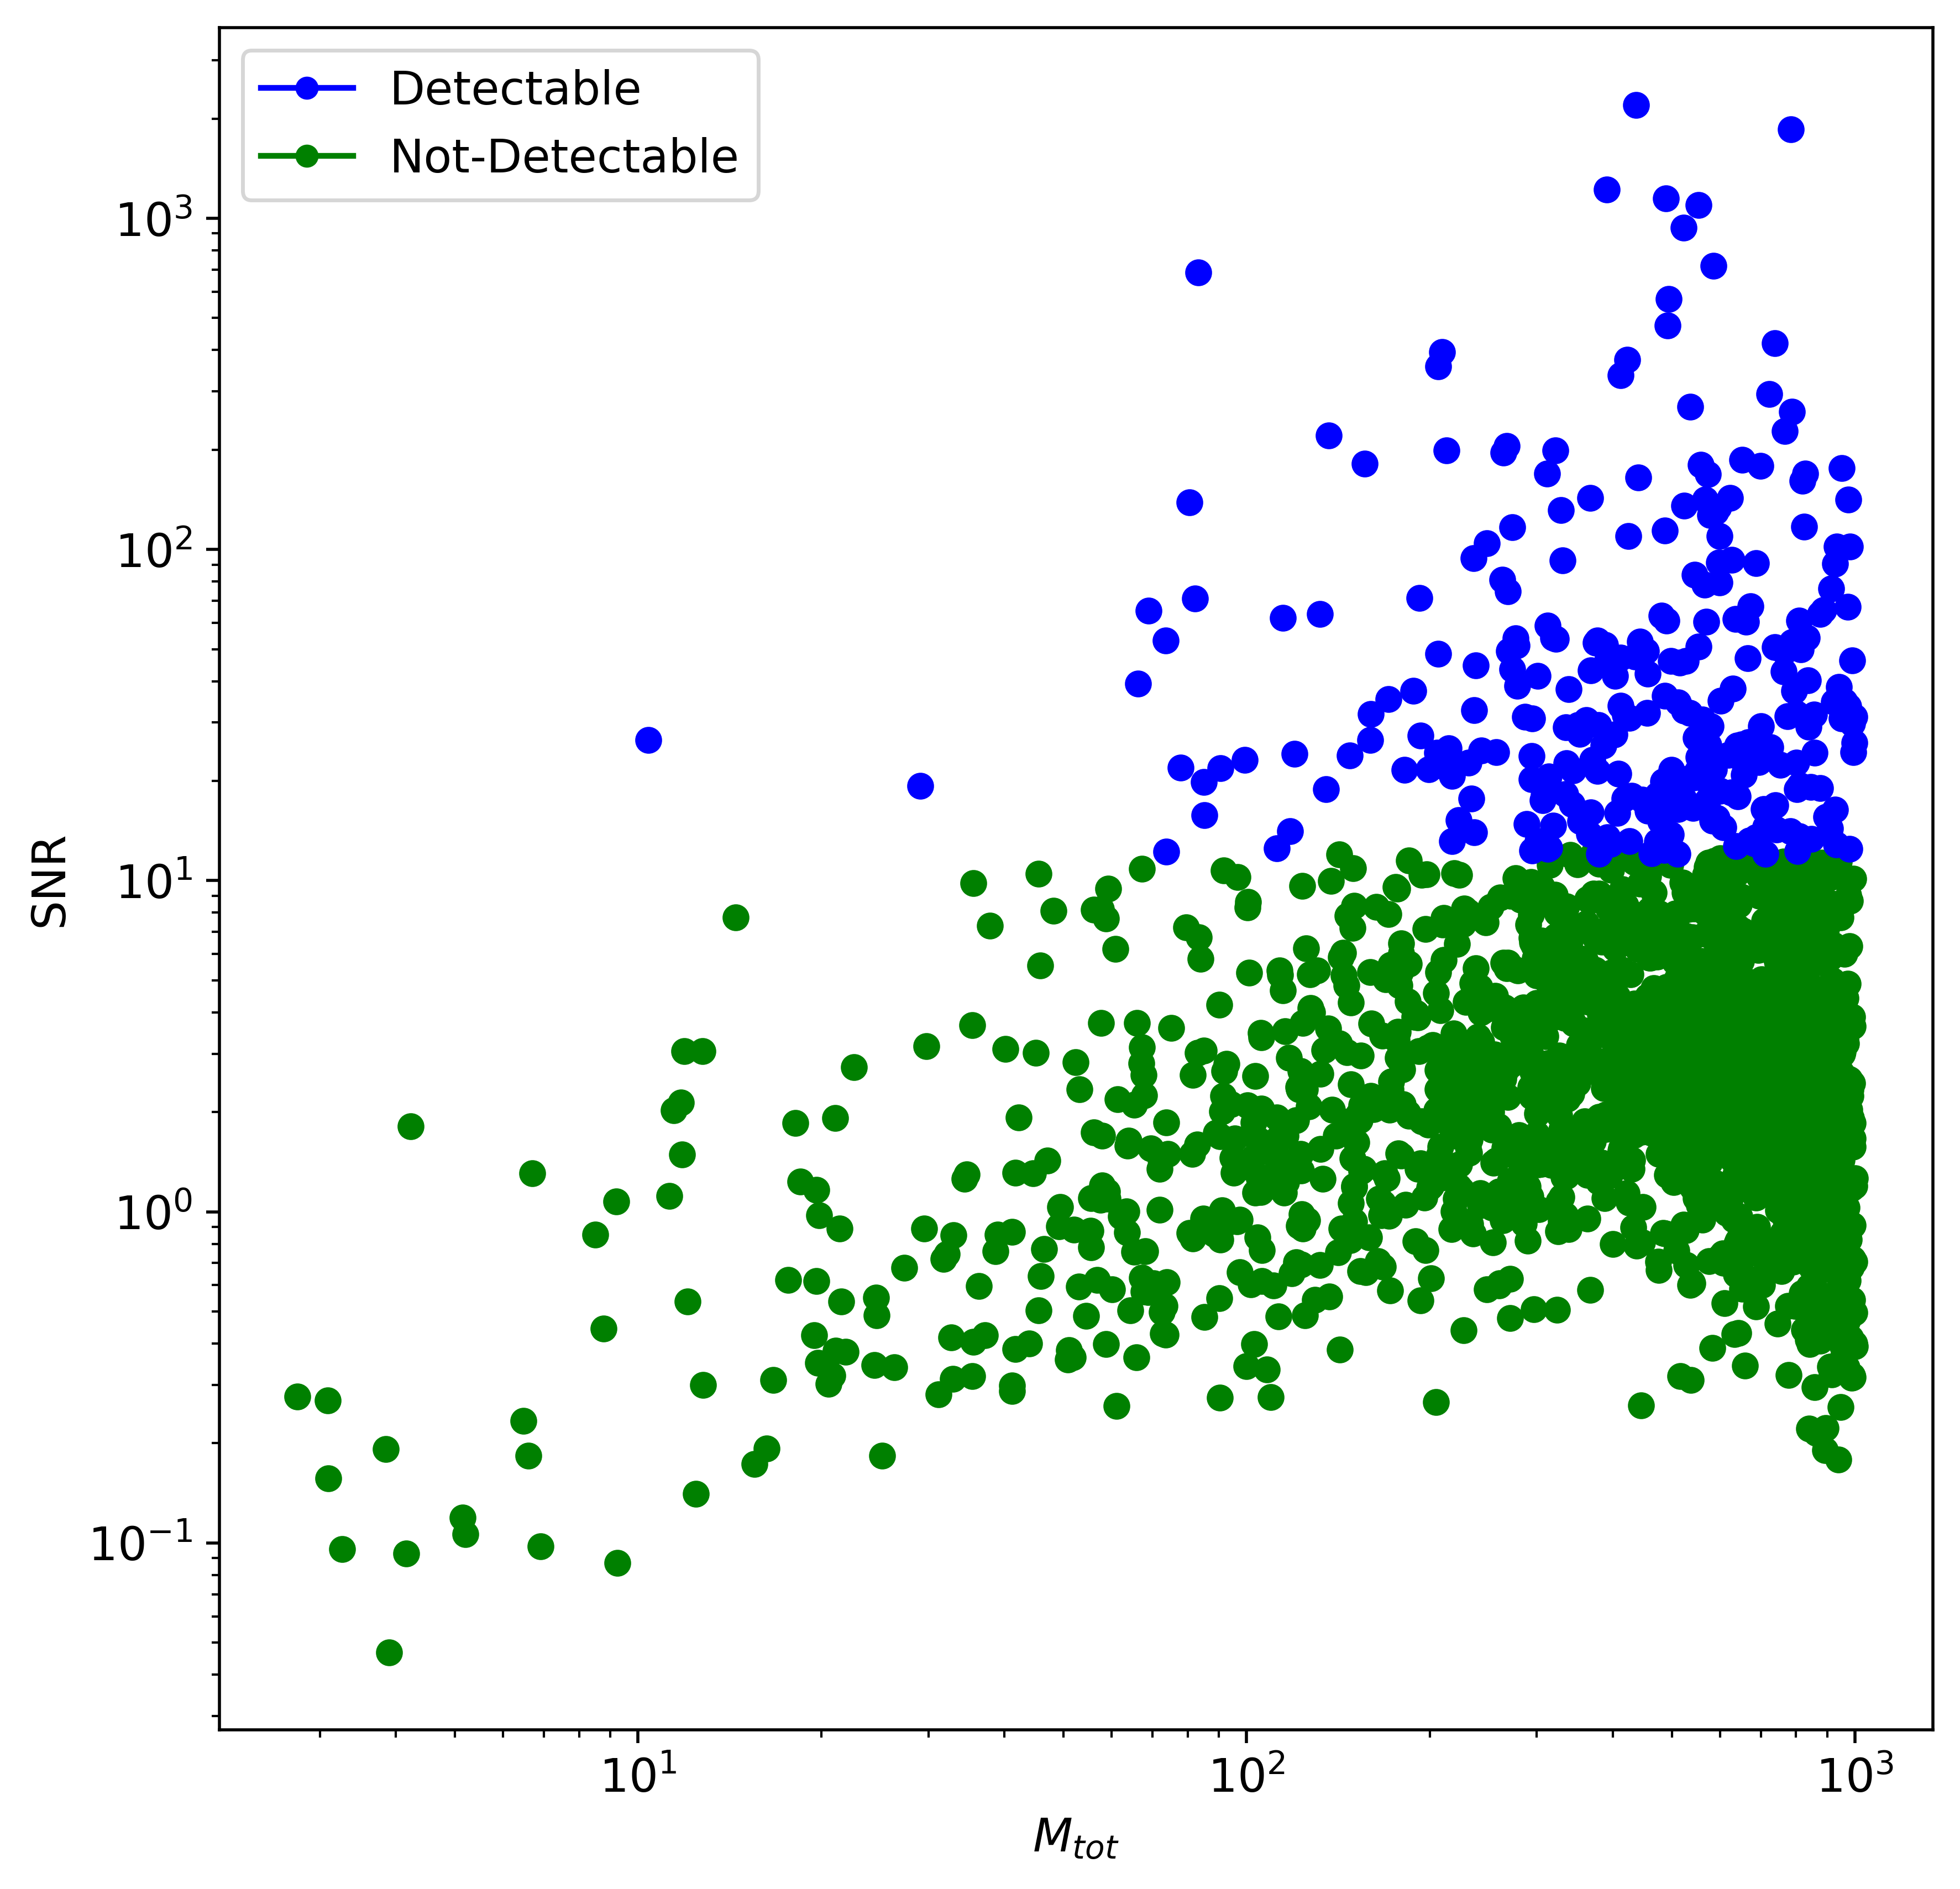

In [80]:
fig, ax = plt.subplots()


legend_elements = [Line2D([0], [0], marker='.', color=colors[1], label='Detectable', markersize=10),
                   Line2D([0], [0], marker='.', color=colors[0], label='Not-Detectable', markersize=10)]

burn = 2000
for i in range(2):
    ax.scatter(mtot[:burn][det[:burn]==i], snr[:burn][det[:burn]==i], c=colors[i])


plt.xlabel(r'$M_{tot}$')
plt.ylabel('SNR')
plt.loglog()
plt.legend(handles=legend_elements)
plt.show()

/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_83559/2502181812.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(det[:burn][blue], snr[:burn][blue], c='blue')


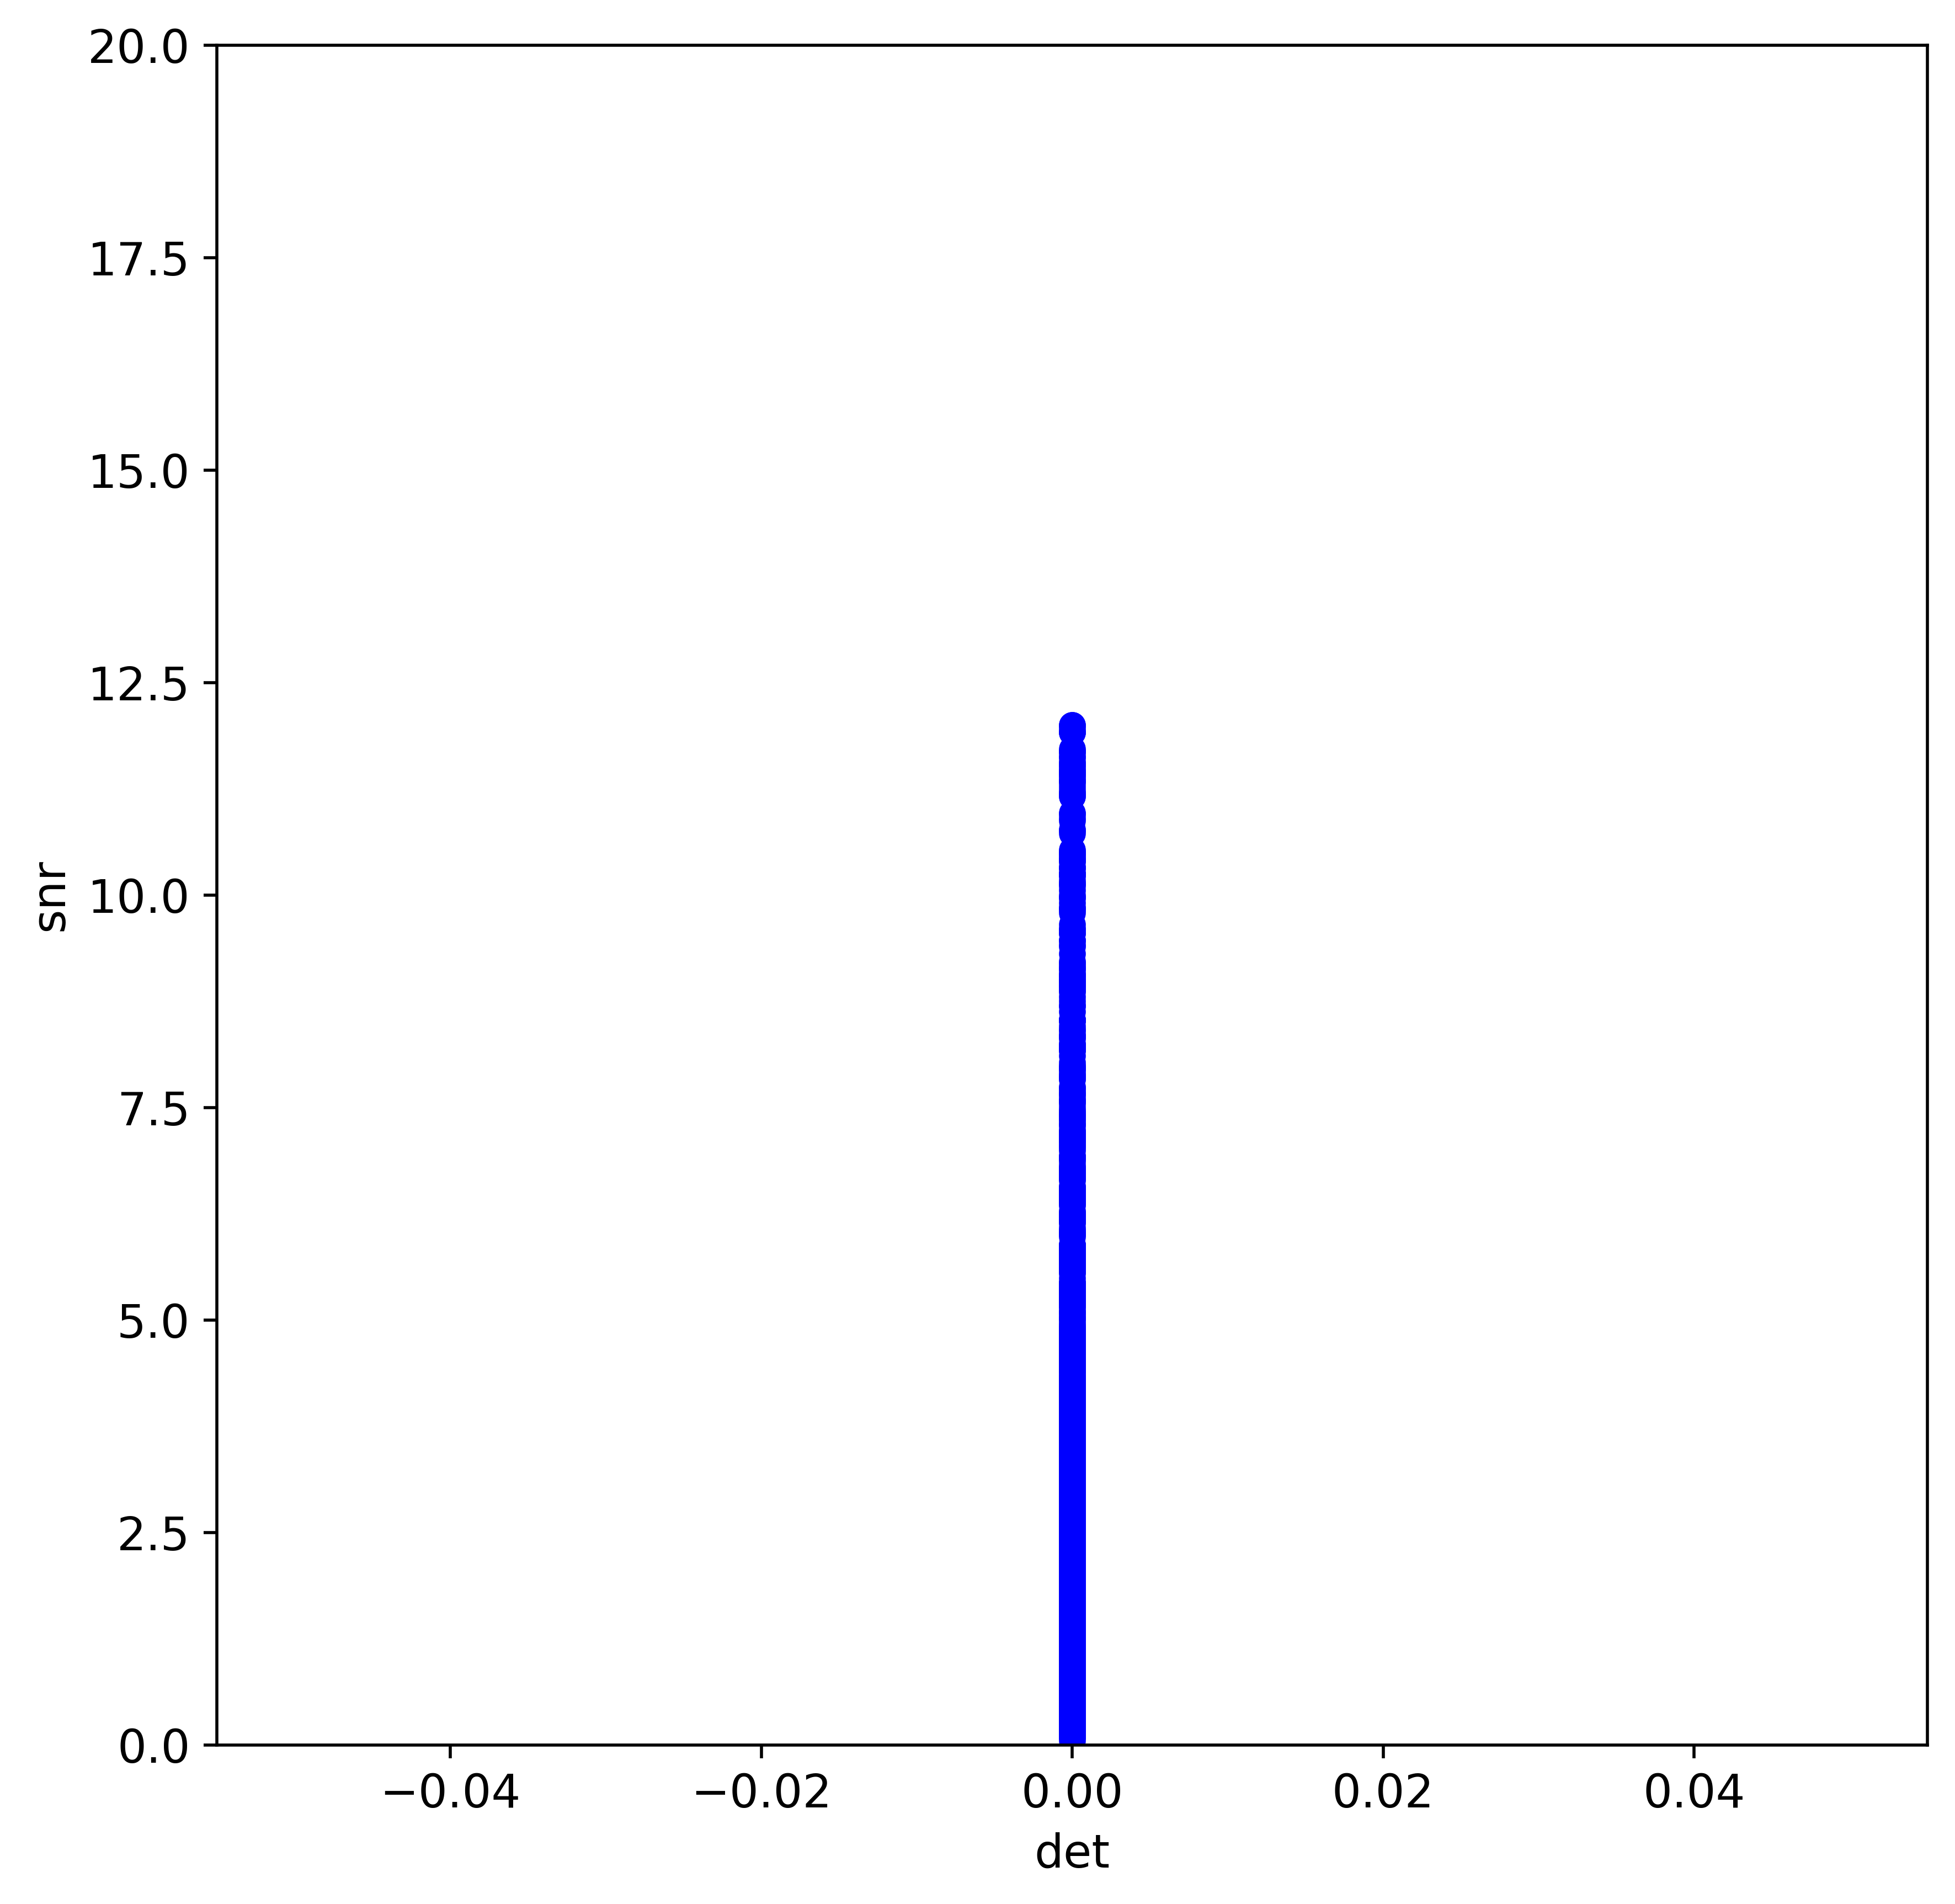

In [85]:
burn = 2000
blue = [det[:burn] == 0]
red = [det[:burn] == 1]

plt.scatter(det[:burn][blue], snr[:burn][blue], c='blue')
#plt.scatter(det[:burn][red], snr[:burn][red], c='red')
plt.xlabel('det')
plt.ylabel('snr')
plt.ylim(0, 20);

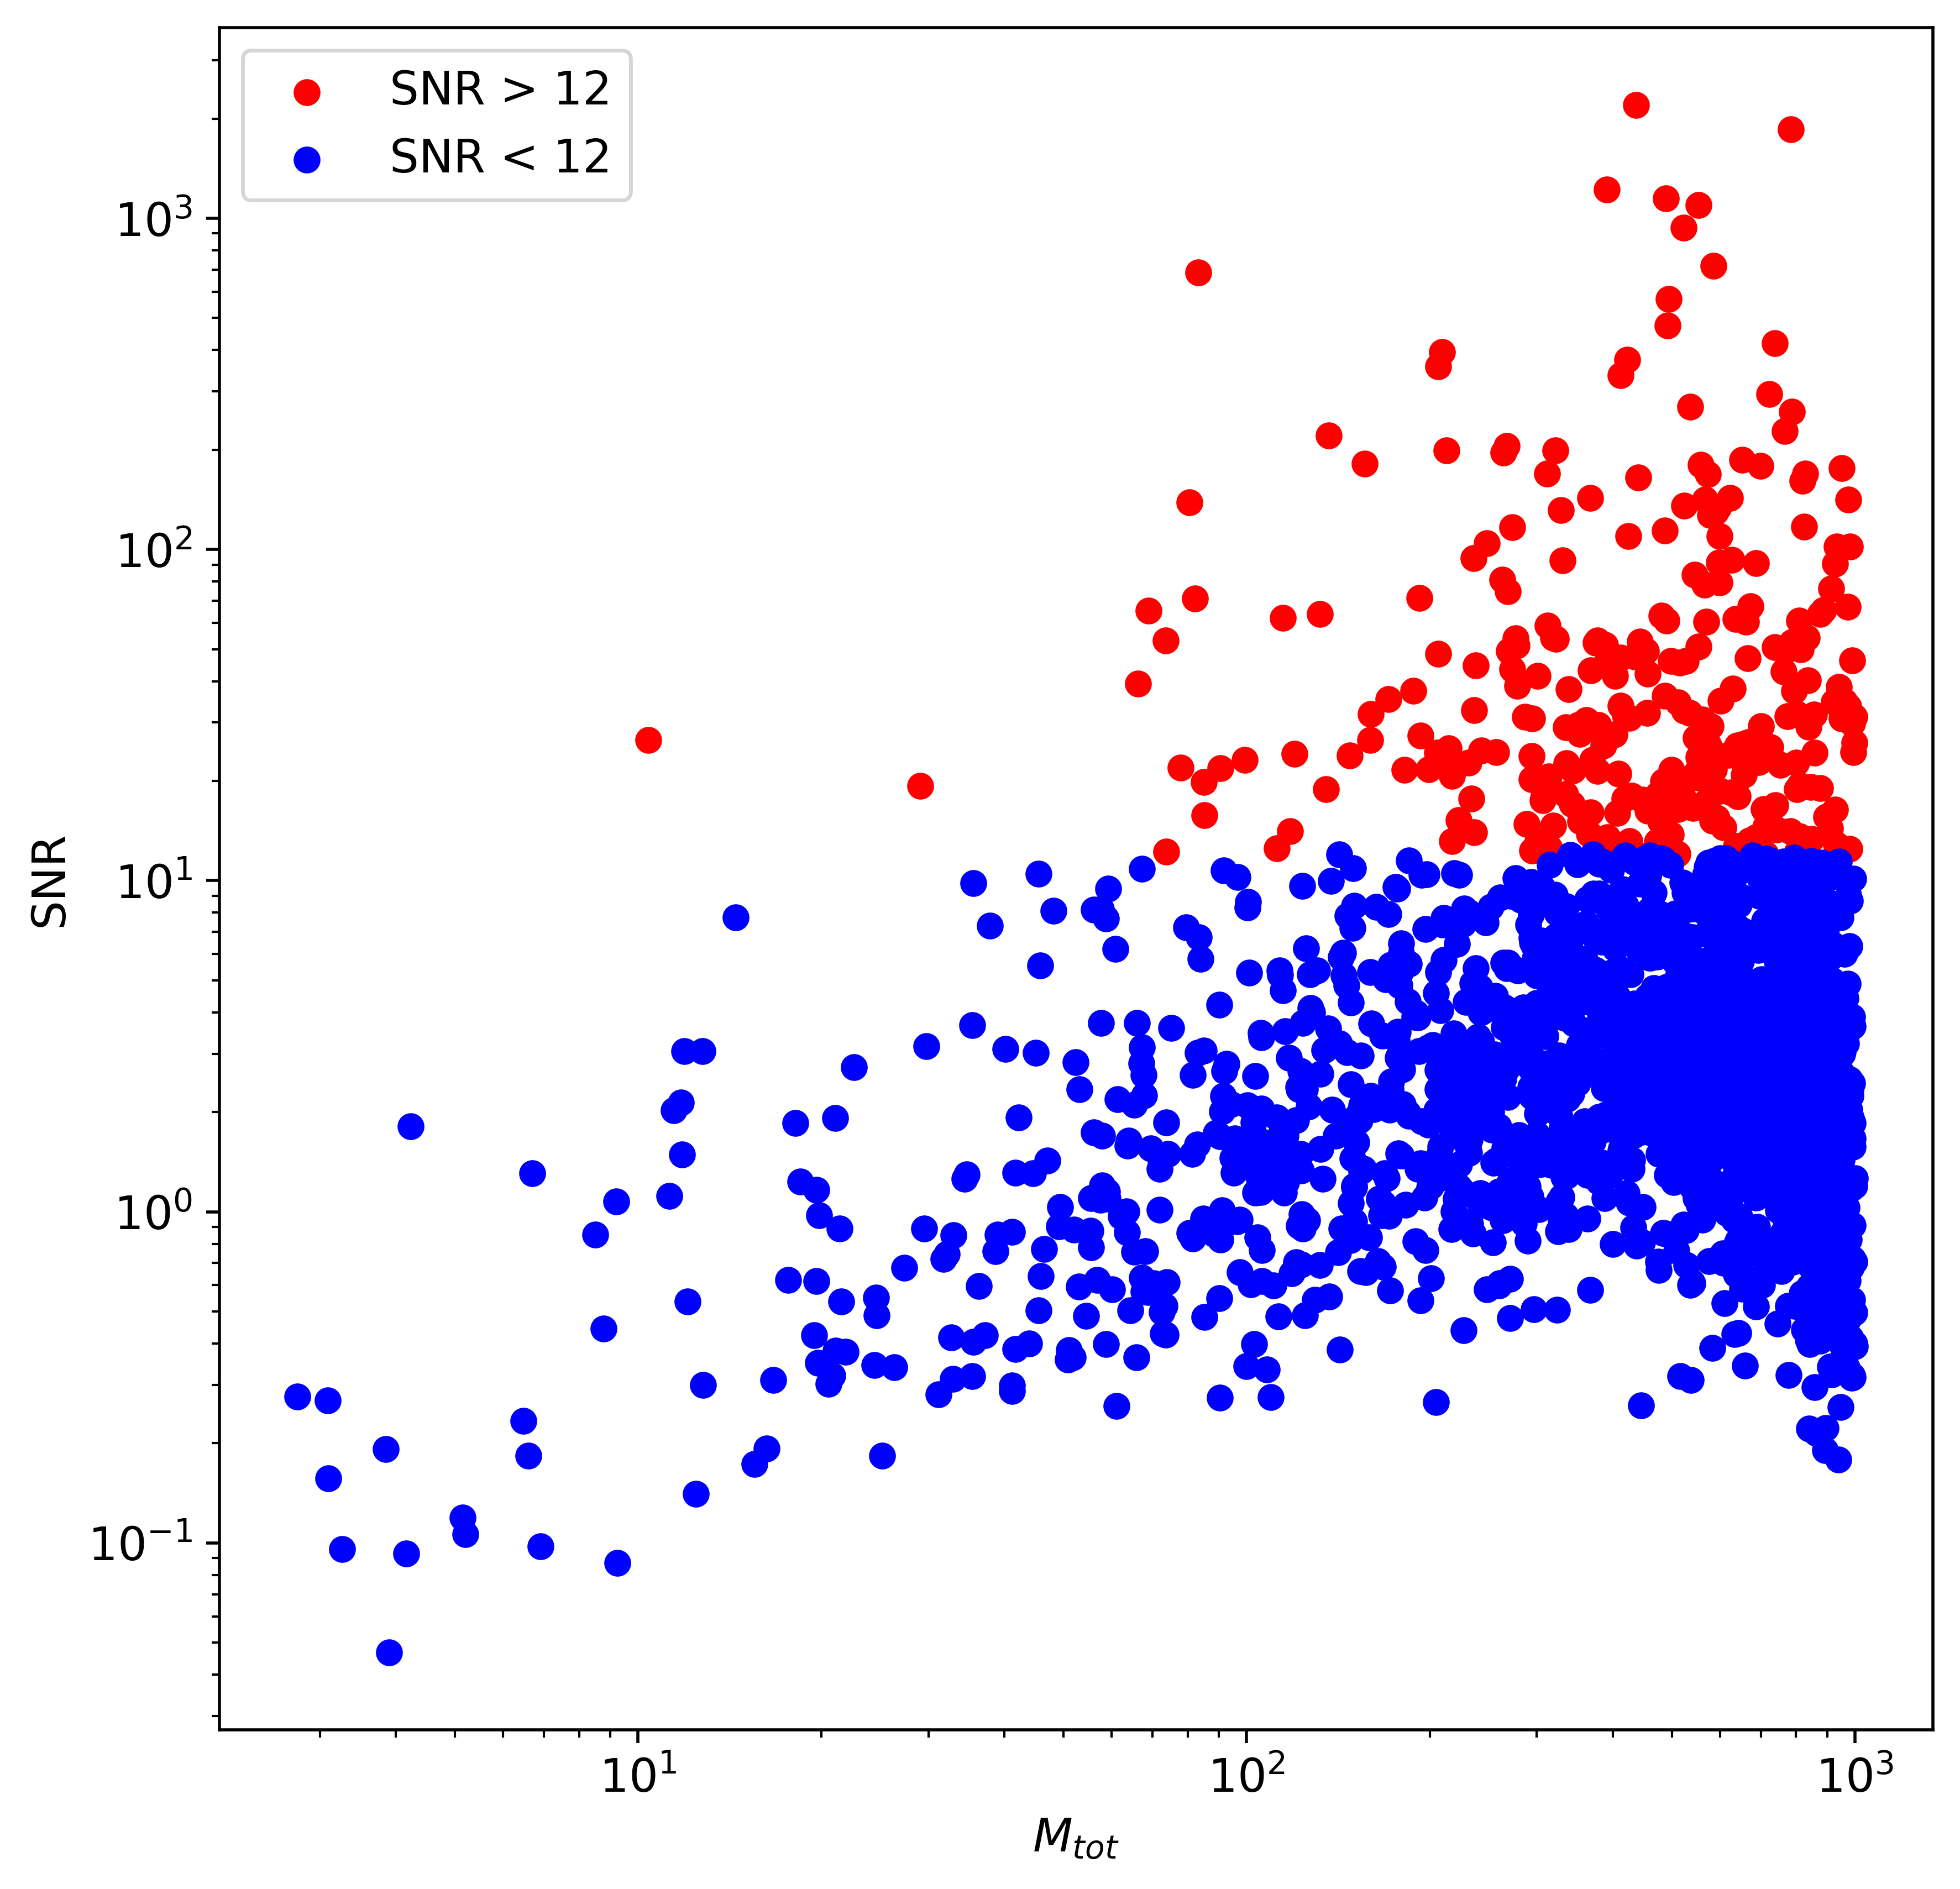

In [96]:
fig, ax = plt.subplots()


legend_elements = [Line2D([0], [0], marker='.', color=colors[1], label='Detectable', markersize=10),
                   Line2D([0], [0], marker='.', color=colors[0], label='Not-Detectable', markersize=10)]

burn = 2000
red = tuple([det[:burn] == 1])
blue = tuple([det[:burn] == 0])

for m, label, c in zip([red, blue], ['SNR > 12', 'SNR < 12'], ['red', 'blue']):
    ax.scatter(mtot[:burn][m], snr[:burn][m], label=label, c=c)


plt.xlabel(r'$M_{tot}$')
plt.ylabel('SNR')
plt.loglog()
plt.legend()
#plt.legend(handles=legend_elements)
plt.show()

In [114]:


reg = sklearn.linear_model.LinearRegression()

xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
    mtot, det, test_size = 0.75)

reg.fit(xtrain, ytrain)

ypred = reg.predict(xtest)

fpr, tpr, thresh = roc_curve(ytest, ypred)

plt.plot(fpr, tpr)

TypeError: Indexing elements must be in increasing order

In [130]:
dset = h5py.File(file)
dset.keys()


<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

In [149]:
#H5py read_in_files are not treated as numpy arrays!!
#Creating new ones by appending

downsample = int(1e3)
data = []

#Leaving out 'det' for training purposes
for key in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']:
    data.append(dset.get(key)[:downsample])

#Numpy array conversion and transposing rows and columns
data = np.array(data).T

In [151]:
valid = np.array(dset['det'][:downsample])

Text(0, 0.5, 'true positive rate')

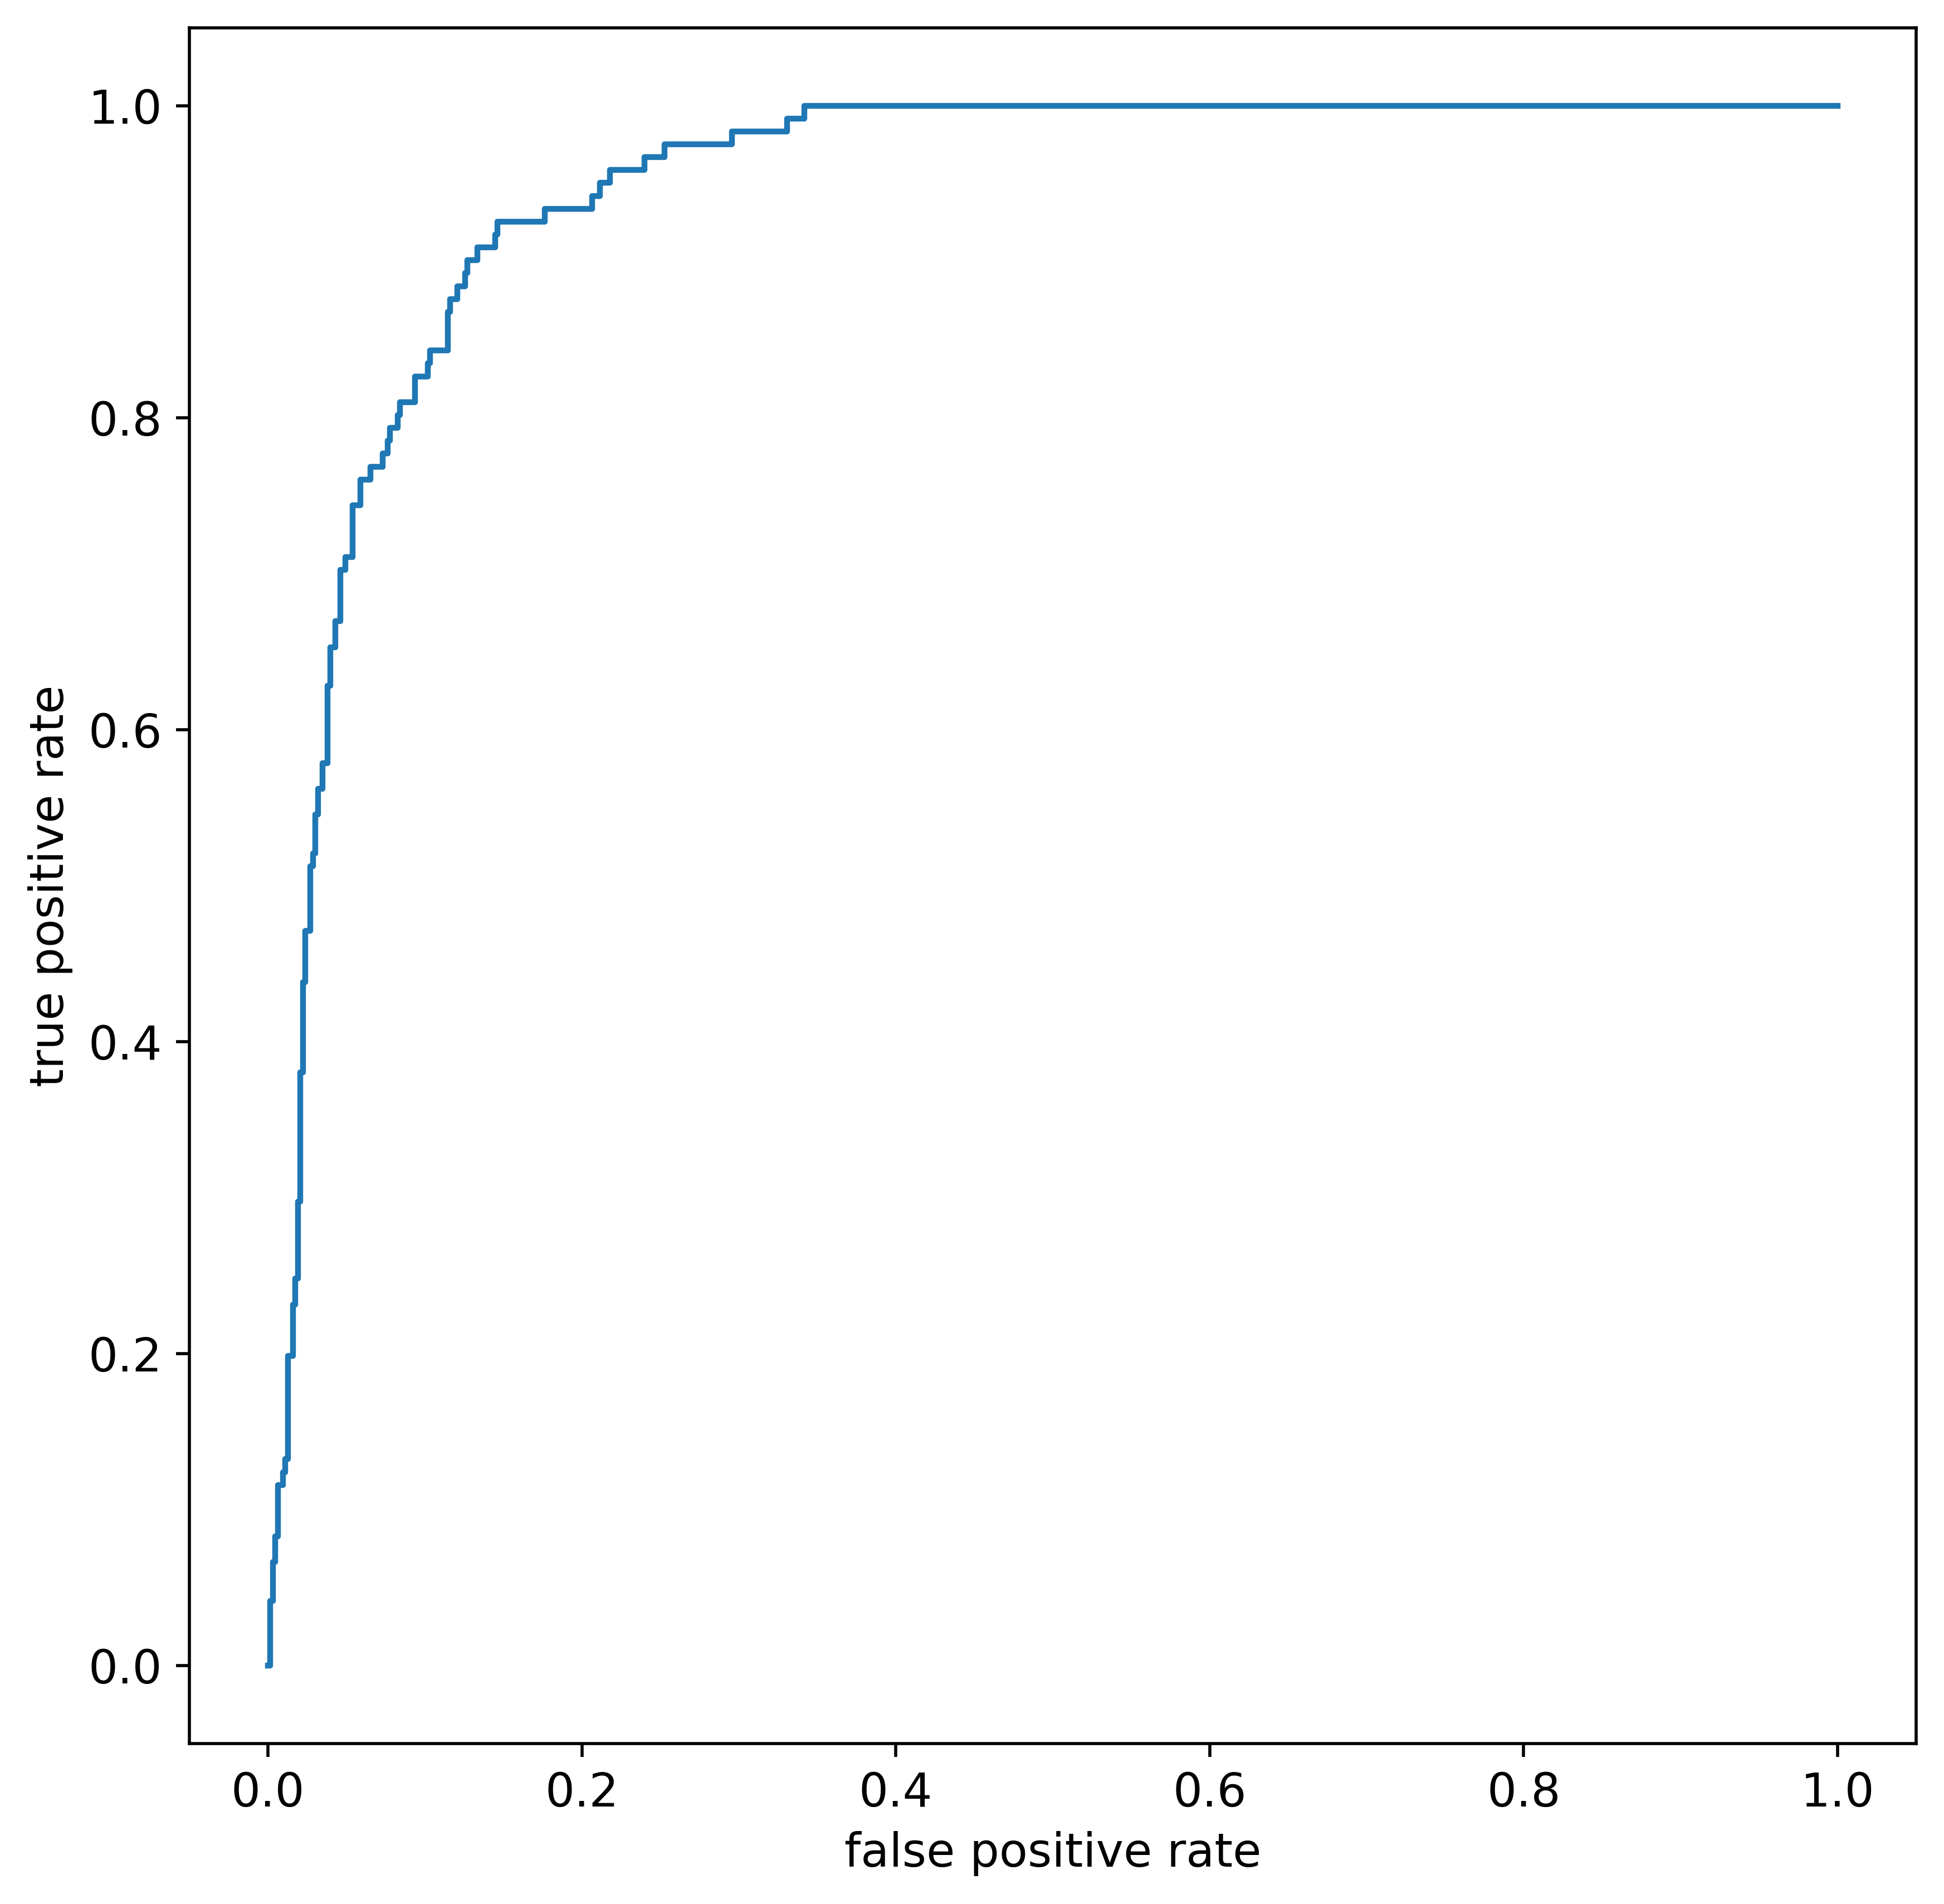

In [152]:
reg = sklearn.linear_model.LinearRegression()

xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
    data, valid, test_size = 0.75)

reg.fit(xtrain, ytrain)

ypred = reg.predict(xtest)

fpr, tpr, thresh = roc_curve(ytest, ypred)

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

In [153]:

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, valid, test_size=0.3, random_state=42)
clf = DecisionTreeClassifier(random_state=0, max_depth=10,criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

In [155]:
y_pred = clf.predict(X_test)
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
C

array([[243,  13],
       [  6,  38]])

In [161]:
completeness_test = []
contamination_test = []
completeness_train = []
contamination_train = []

md_vals = np.arange(1,20)
for md in md_vals:
    clf = DecisionTreeClassifier(random_state=0, max_depth=md,criterion='entropy')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    C = sklearn.metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = C.ravel()
    completeness_test.append(tp/(tp+fn))
    contamination_test.append(fp/(tp+fp))

    y_pred = clf.predict(X_train)
    C = sklearn.metrics.confusion_matrix(y_train, y_pred)
    tn, fp, fn, tp = C.ravel()
    completeness_train.append(tp/(tp+fn))
    contamination_train.append(fp/(tp+fp))

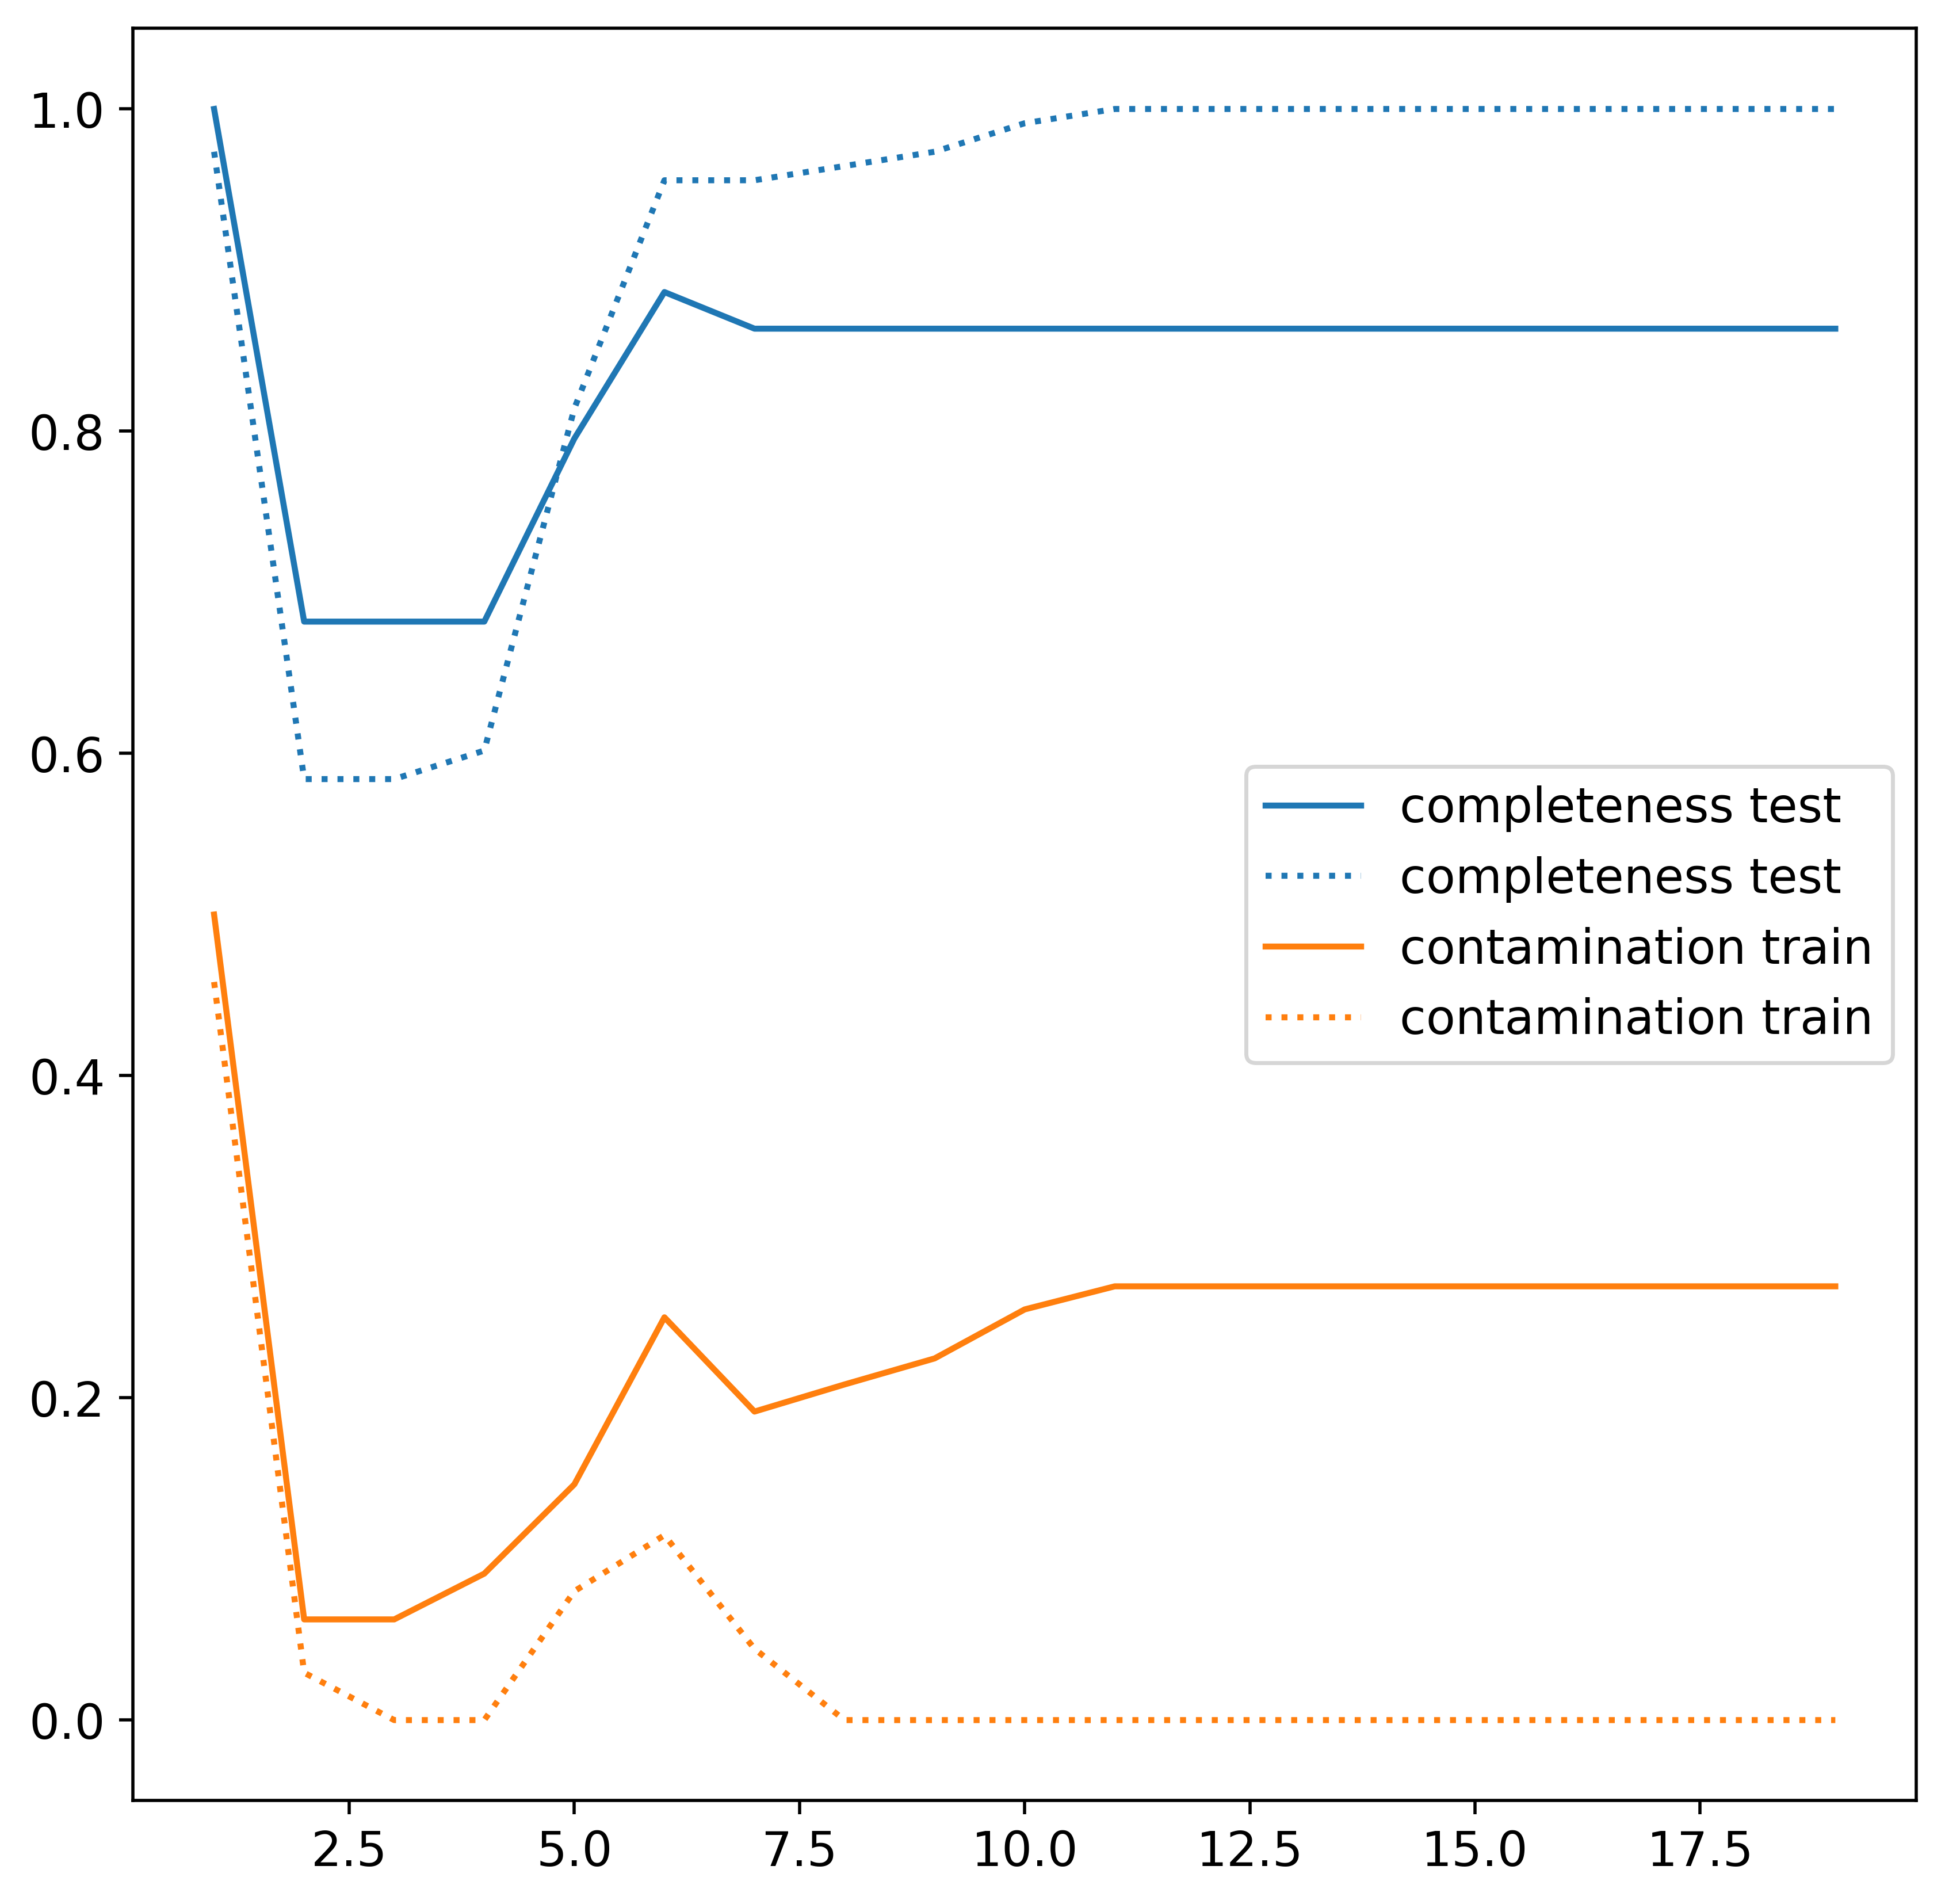

In [162]:
plt.plot(md_vals,completeness_test,label='completeness test',c='C0')
plt.plot(md_vals,completeness_train,label='completeness test',c='C0',ls='dotted')

plt.plot(md_vals,contamination_test,label='contamination train',c='C1')
plt.plot(md_vals,contamination_train,label='contamination train',c='C1',ls='dotted')
plt.legend()